### Dropout regularization 
When building effective deep learning models, we frequently encounter the challenge of overfitting, where a model performs exceptionally well on training data but fails to generalize well to unseen data. Regularization techniques are thus critical to ensure our model does not suffer from this common pitfall, striking a balance between bias (underfitting) and variance (overfitting). Regularization methods work by adding a penalty on the complexity of the model, effectively preventing the model fom learning too much noise from the training data and thus enhancing its ability to generalize.

One such powerful regularization techniques is 'Dropout', a concept that metaphorically 'drops out' or temporarily 'turns off' a fraction of neurons in the model during training, thereby reducing the interdependencies of neurons. The randomness introduced by dropping out neurons compels the network to learn more robust features, leading to a more generalized and less overfit model.

Dropout operates differently from most other regularization techniques. Instead of adding a penalty to the loss function, it randomly disables a fraction of neurons (defined by a probability parameter, typically ranging from 0.2 to 0.5), effectively creating a different architecture of the network for each training instance. This can be seen as training an ensemble of networks, which results in a more robust and generalizable final model.

In this section , we will delve into the nuances of dropout, explore its theoretical underpinnings, and illustrate how to apply it using valious deep learning frameworks. Understanding and correctly implementing dropout is a valuable tool in the deep learning practitioner's toolkit, aiding the creation of robust and generalized models.

As we go through the chapter, you will understand how dropout fits perfectly into the grand schema of regularization methods, learn about its benefits and limitations, and grasp how to effectively use dropout in your deep learning models.

Dropout is a regularization technique that was introduced by Geoffrey Hinton, a pioneer in the field of deep learning, and his students Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, and Ruslan Salakhutdinov in a paper titled "Dropout: A Simple Way to Prevent Neural Networks from Overfitting," which was published in 2014.

The development of dropout came from the recognition of the challenges with overfitting in large neural networks. Large neural networks with millions of parameters are prone to overfitting because of their capacity to memorize training data. This is specially true when the amount of training data available is small relative to the complexity of the network.

Goeofrrey Hinton, who is often referred as the "godfather of deep learning", has made several seminal contributions to the field of artificial intelligence, with dropout being just one of them. He and his team were looking for simple and effective ways to make neural networks more robust and to improve their generalization capabilities. Inspired by biological systems, they proposed the idea of dropout, which involves randomly "dropping out" or deactivating a subset of neurons during the training process to prevent them from co-adapting too much to the data.

This simple yet effective technique has since been widely adopted in the deep learning community and has formed the basis of numerous subsequent research and developments. Dropout has proven to be a powerful tool in the training of neural networks, helping to mitigate overfitting and improve model generalization, particularly in scenarios with limited training data.

Using the later example:

In [2]:
import copy
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from scipy.stats import zscore
import matplotlib.pyplot as plt

In [3]:
# selecting d   evice
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# early stopping definition
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement found in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False


print(device)

cpu


In [4]:
# load the data adn fill NA values with the median for all fields
def fill_na_with_median(df):
    """
    Replace all na values in numeric fields with median
    """
    for col in df.columns:
        if df[col].dtype in ['float32', 'int32', 'int64', 'float64', 'long']:
            median = df[col].median()
            df[col] = df[col].fillna(median)
    return df


def load_dataset(route, fill_na=False):
    df = pd.read_csv(route, na_values=["NA", "?"])
    if fill_na:
      df = fill_na_with_median(df)
    return df


df = load_dataset("data/jh-simple-dataset.csv", fill_na=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2000 non-null   int64  
 1   job             2000 non-null   object 
 2   area            2000 non-null   object 
 3   income          2000 non-null   float64
 4   aspect          2000 non-null   float64
 5   subscriptions   2000 non-null   int64  
 6   dist_healthy    2000 non-null   float64
 7   save_rate       2000 non-null   int64  
 8   dist_unhealthy  2000 non-null   float64
 9   age             2000 non-null   int64  
 10  pop_dense       2000 non-null   float64
 11  retail_dense    2000 non-null   float64
 12  crime           2000 non-null   float64
 13  product         2000 non-null   object 
dtypes: float64(7), int64(4), object(3)
memory usage: 218.9+ KB


In [5]:
# generate dummies
def generate_dummies(df, dummies_list, drop_original=True):
    """Generate dummies for certain categorical columns"""
    for col in dummies_list:
        if df[col].dtype in ['object', 'categories']:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, dtype=int)], axis=1)
            if drop_original:
                df.drop(col, axis=1, inplace=True)

    return df

df = generate_dummies(df, ["job", "area", "product"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2000 non-null   int64  
 1   income          2000 non-null   float64
 2   aspect          2000 non-null   float64
 3   subscriptions   2000 non-null   int64  
 4   dist_healthy    2000 non-null   float64
 5   save_rate       2000 non-null   int64  
 6   dist_unhealthy  2000 non-null   float64
 7   age             2000 non-null   int64  
 8   pop_dense       2000 non-null   float64
 9   retail_dense    2000 non-null   float64
 10  crime           2000 non-null   float64
 11  job_11          2000 non-null   int32  
 12  job_al          2000 non-null   int32  
 13  job_am          2000 non-null   int32  
 14  job_ax          2000 non-null   int32  
 15  job_bf          2000 non-null   int32  
 16  job_by          2000 non-null   int32  
 17  job_cv          2000 non-null   i

In [6]:
# standardize ranges
num_fields = ['income', 'aspect', 'save_rate', 'subscriptions']
for field in num_fields:
    df[field] = zscore(df[field])

To add dropout to the existing code, we will use the `nn.Dropout` PyTorch module. It randomly zeroes some of the elements of the input tensor with probability `p` during training, which can help prevent overfitting. The modified code is shown below with the dropout layers added.
```
# Create the model with dropout
model = nn.Sequential(
    nn.Linear(x.shape[1], 20),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(10, 1)
)
```

In [11]:
torch.manual_seed(42)

# prepare features and labels
x_columns = df.columns.drop(["age", "id"])
x = torch.tensor(df[x_columns].values, dtype=torch.float32, device=device)
y = torch.tensor(df[["age"]].values, dtype=torch.float32, device=device)

# initialize k-fold
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# early stopping
patience = 10

# lists to store training and validation losses
train_losses_all_folds = []
val_losses_all_folds = []

epochs = 300
fold = 0
for train_index, test_index in kf.split(x):
    fold += 1
    print(f"Fold {fold}")
    
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    """
     nn.Dropout(0.1) means that 10% of the neurons in the layer immediately before the dropout layer will be randomly deactivated during training.
     First Dropout Layer: nn.Dropout(0.1): This dropout layer randomly sets 10% of the neurons from the previous linear layer (the one with 20 neurons) to zero during each training step. This helps prevent overfitting by introducing randomness and ensuring that the model does not rely too heavily on any single neuron. 
    """
    
    model = nn.Sequential(
        nn.Linear(x.shape[1], 20),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(10, 1),
    ).to(device)
    
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    early_stopping = EarlyStopping(patience=patience)
    
    train_losses = []
    val_losses = []
    epoch = 0
    done = False
    
    while not done and epoch < epochs:
        epoch += 1
        model.train()
        batch_losses = []
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        train_loss = sum(batch_losses) / len(batch_losses)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            val_output = model(x_test)
            val_loss = loss_fn(val_output, y_test).item()
        val_losses.append(val_loss)
        
        if early_stopping(model, val_loss):
            done = True
        
    print(f"Fold {fold}, epoch {epoch}/{epochs}, Train loss: {train_loss:.4f}, Val loss {val_loss:.4f}, {early_stopping.status}")
    
    train_losses_all_folds.append(train_losses)
    val_losses_all_folds.append(val_losses)


Fold 1
Fold 1, epoch 146/300, Train loss: 40.1878, Val loss 4.1386, Early stopping triggered after 10 epochs
Fold 2
Fold 2, epoch 154/300, Train loss: 50.0333, Val loss 4.1348, Early stopping triggered after 10 epochs
Fold 3
Fold 3, epoch 126/300, Train loss: 46.1972, Val loss 6.0942, Early stopping triggered after 10 epochs
Fold 4
Fold 4, epoch 141/300, Train loss: 50.5844, Val loss 4.5505, Early stopping triggered after 10 epochs
Fold 5
Fold 5, epoch 146/300, Train loss: 35.5547, Val loss 3.4853, Early stopping triggered after 10 epochs


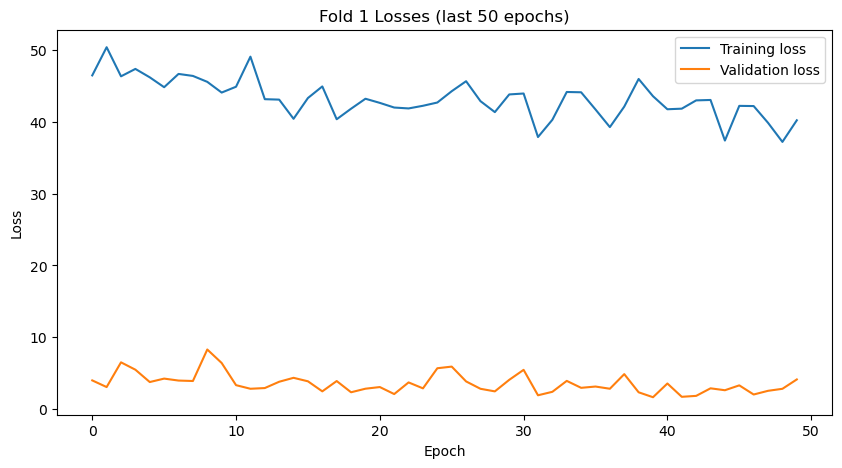

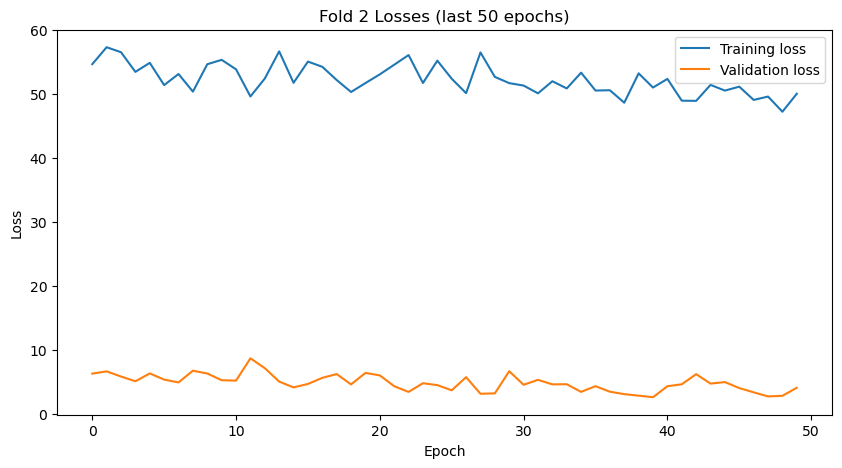

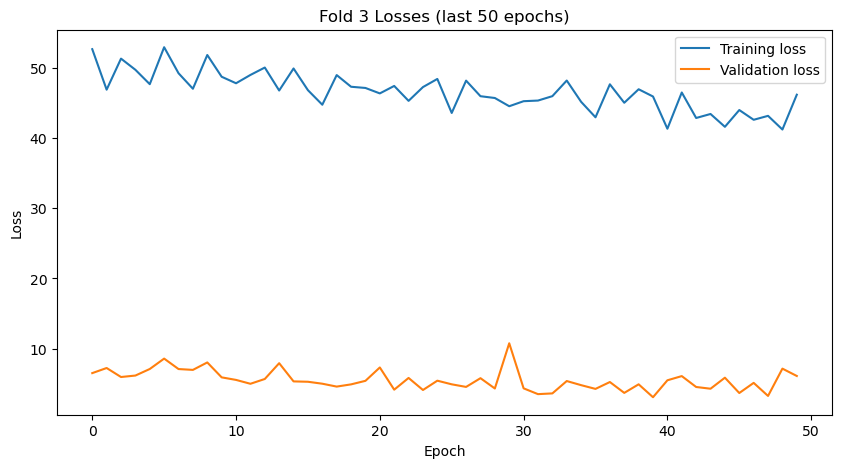

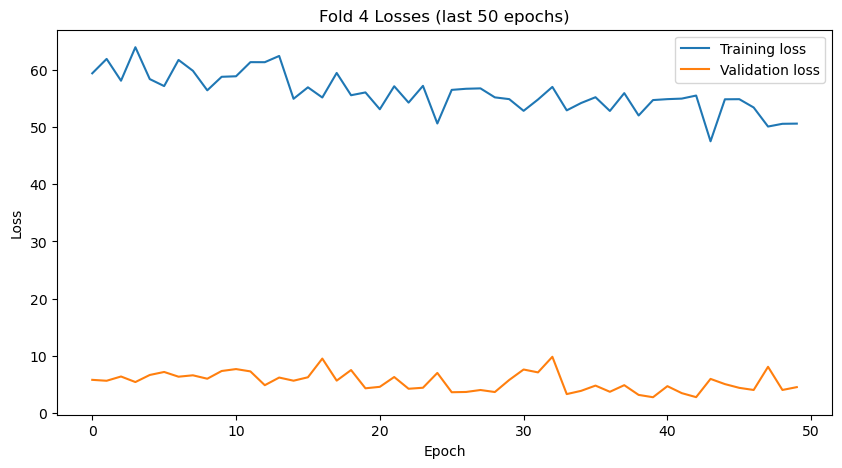

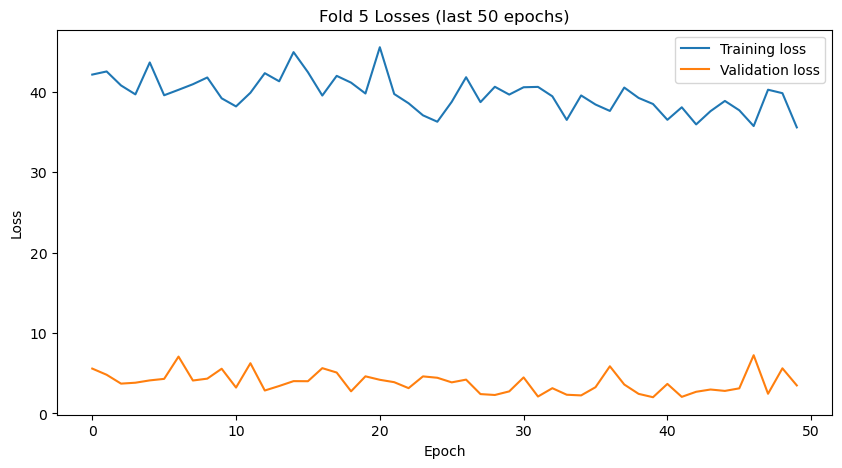

In [12]:
# function to plot the last n epochs train and test losses of each fold
def plot_last_n_epochs(train_los, val_los, n):
    for i in range(len(train_losses_all_folds)):
        train = train_los[i]
        val = val_los[i]
        
        plt.figure(figsize=(10, 5))
        plt.plot(train[-n:], label='Training loss')
        plt.plot(val[-n:], label='Validation loss')
        plt.title(f"Fold {i + 1} Losses (last {n} epochs)")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

plot_last_n_epochs(train_losses_all_folds, val_losses_all_folds, 50)

In [13]:
# Function to reset weights and biases
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# Apply the reset function to each layer
model.apply(reset_weights)

Sequential(
  (0): Linear(in_features=53, out_features=20, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=20, out_features=10, bias=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)

The changes to the code are straightforward, we simply add Dropout layers in our model's architecture. Here, we've added two Dropout layers, one between the first linear layer and the second linear layer, and another between the second linear layer and the third. Each dropout layer will randomly set 10% of input elements to zero during training. `Dropout layers are typically added after non-linear activation functions, such as ReLU in this case`.

Dropout is a regularization technique that prevents overfitting by reducing the interdependent learning amongst the neurons, encouraging individual neuron to be independently capable. During the training, dropout will randomly disable some neurons which forces the data to find new paths to propagate through the network. Consequently, this results in a network that is capable of better generalization and is less likely to overfit the training data.